In [1]:
# Add path
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), "src"))

# Import popexposure 
from popexposure.estimate_exposure import PopEstimator
from popexposure.data_loader import DataReader as dr
from popexposure.geometry_validator import GeometryValidator as gv
from popexposure.geometry_operations import GeometryOperations as go

# Additional imports
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from shapely.geometry import (
    Point,
    Polygon,
    LineString,
    MultiPolygon,
    GeometryCollection,
)
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import sys

# Create data directory in home directory if it doesn't exist
data_dir = Path.cwd() / "data"
print(f"Data directory: {data_dir}")

Data directory: /Volumes/squirrel-utopia/popexposure/tests/data


In [3]:
# Make raster
# Define raster parameters
width, height = 100, 100
# Bounds: longitude from -122 to -121, latitude from 37 to 38 (California Bay Area)
west, south, east, north = -122.0, 37.0, -121.0, 38.0
transform = from_bounds(west, south, east, north, width, height)

# Create population data - higher values in center, lower at edges
x = np.linspace(0, width - 1, width)
y = np.linspace(0, height - 1, height)
X, Y = np.meshgrid(x, y)

# Create a population distribution (higher in center)
center_x, center_y = width // 2, height // 2
pop_data = (
    np.exp(-((X - center_x) ** 2 + (Y - center_y) ** 2) / (width / 4) ** 2)
    * 1000
)
pop_data = pop_data.astype(np.float32)

# Write the raster
# Define output path
output_path = data_dir / "test_population_raster.tif"
# Write 
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=np.float32,
    crs="EPSG:4326",  # WGS84
    transform=transform,
    nodata=0,
) as dst:
    dst.write(pop_data, 1)

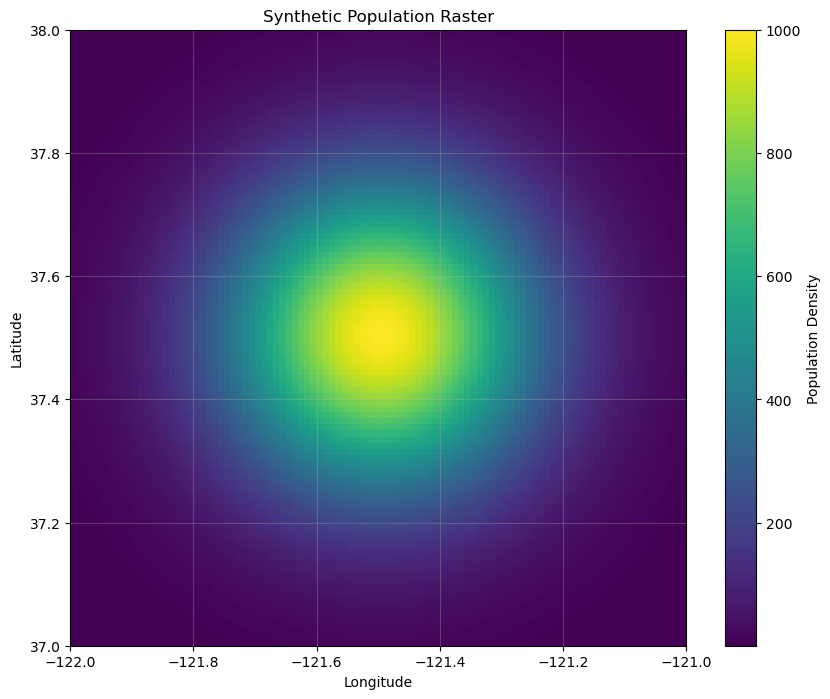

In [4]:
# Visualize the created raster
plt.figure(figsize=(10, 8))
plt.imshow(
    pop_data, 
    extent=[west, east, south, north], 
    cmap="viridis", 
    origin="lower"
)
plt.colorbar(label="Population Density")
plt.title("Synthetic Population Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Make test dataset of admin units and hazard geometries and buffer distances 

# Create test hazard geometries within our raster bounds (-122 to -121, 37 to 38)
hazard_geometries = [
    # 1. Point at center (should have high population exposure)
    Point(-121.5, 37.5),
    
    # 2. Polygon covering center area
    Polygon([
        (-121.6, 37.4),
        (-121.4, 37.4),
        (-121.4, 37.6),
        (-121.6, 37.6),
        (-121.6, 37.4),
    ]),
    
    # 3. MultiPolygon (two separate areas - edge and center)
    MultiPolygon([
        Polygon([
            (-121.8, 37.2),
            (-121.7, 37.2),
            (-121.7, 37.3),
            (-121.8, 37.3),
            (-121.8, 37.2),
        ]),
        Polygon([
            (-121.3, 37.7),
            (-121.2, 37.7),
            (-121.2, 37.8),
            (-121.3, 37.8),
            (-121.3, 37.7),
        ]),
    ]),
    
    # 4. LineString (represents a road, fault line, or pipeline)
    LineString([(-121.9, 37.1), (-121.5, 37.5), (-121.1, 37.9)]),
    
    # 5. GeometryCollection 
    GeometryCollection([
        Point(-121.4, 37.3),  
        LineString([(-121.45, 37.25), (-121.35, 37.35)]),  
        Polygon([
            (-121.5, 37.2),
            (-121.3, 37.2),
            (-121.3, 37.4),
            (-121.5, 37.4),
            (-121.5, 37.2),
        ]),  
    ]),
    
    # 6. Another Point (different location)
    Point(-121.2, 37.8),
    
    # 7. Missing geometry (None) - will test error handling
    None,
    
    # 8. Invalid polygon (all points the same - should be handled gracefully)
    Polygon([(-121.7, 37.5), (-121.7, 37.5), (-121.7, 37.5), (-121.7, 37.5)]),
]

# Create test data with hazard IDs and buffer distances
hazard_data = {
    'ID_hazard': [
        'wildfire_001',
        'industrial_facility_002', 
        'flood_zone_003',
        'pipeline_004',
        'earthquake_complex_005',
        'oil_well_006',
        'missing_hazard_007',
        'invalid_polygon_008'
    ],
    'buffer_dist_100': [100, 100, 100, 100, 100, 100, 100, 100],  # 100m buffers
    'buffer_dist_500': [500, 500, 500, 500, 500, 500, 500, 500],  # 500m buffers
    'geometry': hazard_geometries
}

# Create GeoDataFrame
hazards_gdf = gpd.GeoDataFrame(hazard_data, crs="EPSG:4326")

In [6]:
# Save as GeoJSON
geojson_path = data_dir / "test_hazards.geojson"
hazards_gdf.to_file(geojson_path, driver="GeoJSON")

# Save as Parquet  
parquet_path = data_dir / "test_hazards.parquet"
hazards_gdf.to_parquet(parquet_path)

In [7]:
print(hazards_gdf)

                 ID_hazard  buffer_dist_100  buffer_dist_500  \
0             wildfire_001              100              500   
1  industrial_facility_002              100              500   
2           flood_zone_003              100              500   
3             pipeline_004              100              500   
4   earthquake_complex_005              100              500   
5             oil_well_006              100              500   
6       missing_hazard_007              100              500   
7      invalid_polygon_008              100              500   

                                            geometry  
0                                POINT (-121.5 37.5)  
1  POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37....  
2  MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121...  
3  LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3...  
4  GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES...  
5                                POINT (-121.2 37.8)  
6                                     

In [8]:
# Create test administrative units (spatial units) dataset as a grid

# Raster bounds: longitude from -122 to -121, latitude from 37 to 38
west, south, east, north = -122.0, 37.0, -121.0, 38.0

# Create a 3x3 grid of administrative units covering the entire raster
grid_cols = 3  # 3 columns
grid_rows = 3  # 3 rows

# Calculate grid cell dimensions
cell_width = (east - west) / grid_cols  # ~0.333 degrees
cell_height = (north - south) / grid_rows  # ~0.333 degrees

admin_geometries = []
admin_ids = []

# Create grid cells
for row in range(grid_rows):
    for col in range(grid_cols):
        # Calculate cell boundaries
        cell_west = west + col * cell_width
        cell_east = west + (col + 1) * cell_width
        cell_south = south + row * cell_height
        cell_north = south + (row + 1) * cell_height
        
        # Create polygon for this grid cell
        cell_polygon = Polygon([
            (cell_west, cell_south),   # Bottom-left
            (cell_east, cell_south),   # Bottom-right
            (cell_east, cell_north),   # Top-right
            (cell_west, cell_north),   # Top-left
            (cell_west, cell_south)    # Close polygon
        ])
        
        # Generate metadata for this cell
        cell_id = f"grid_{row:02d}_{col:02d}"
        
        admin_geometries.append(cell_polygon)
        admin_ids.append(cell_id)


# Create administrative units data
admin_data = {
    'ID_admin_unit': admin_ids,
    'geometry': admin_geometries
}

# Create GeoDataFrame for administrative units
admin_gdf = gpd.GeoDataFrame(admin_data, crs="EPSG:4326")

print(admin_gdf)

  ID_admin_unit                                           geometry
0    grid_00_00  POLYGON ((-122 37, -121.66667 37, -121.66667 3...
1    grid_00_01  POLYGON ((-121.66667 37, -121.33333 37, -121.3...
2    grid_00_02  POLYGON ((-121.33333 37, -121 37, -121 37.3333...
3    grid_01_00  POLYGON ((-122 37.33333, -121.66667 37.33333, ...
4    grid_01_01  POLYGON ((-121.66667 37.33333, -121.33333 37.3...
5    grid_01_02  POLYGON ((-121.33333 37.33333, -121 37.33333, ...
6    grid_02_00  POLYGON ((-122 37.66667, -121.66667 37.66667, ...
7    grid_02_01  POLYGON ((-121.66667 37.66667, -121.33333 37.6...
8    grid_02_02  POLYGON ((-121.33333 37.66667, -121 37.66667, ...


In [9]:
# Save administrative units as GeoJSON
admin_geojson_path = data_dir / "test_admin_units_grid.geojson"
admin_gdf.to_file(admin_geojson_path, driver="GeoJSON")

# Save administrative units as Parquet
admin_parquet_path = data_dir / "test_admin_units_grid.parquet"
admin_gdf.to_parquet(admin_parquet_path)

In [10]:
# Init popestimator
est = PopEstimator()



In [11]:
hazards = dr.read_geospatial_file(path = parquet_path)
hazards

,ID_hazard,buffer_dist_100,buffer_dist_500,geometry
0,wildfire_001,100,500,POINT (-121.5 37.5)
1,industrial_facility_002,100,500,"POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37...."
2,flood_zone_003,100,500,"MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121..."
3,pipeline_004,100,500,"LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3..."
4,earthquake_complex_005,100,500,"GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES..."
5,oil_well_006,100,500,POINT (-121.2 37.8)
6,missing_hazard_007,100,500,None
7,invalid_polygon_008,100,500,"POLYGON ((-121.7 37.5, -121.7 37.5, -121.7 37...."


In [12]:
hazards = dr.read_geospatial_file(path = geojson_path)
hazards

,ID_hazard,buffer_dist_100,buffer_dist_500,geometry
0,wildfire_001,100,500,POINT (-121.5 37.5)
1,industrial_facility_002,100,500,"POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37...."
2,flood_zone_003,100,500,"MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121..."
3,pipeline_004,100,500,"LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3..."
4,earthquake_complex_005,100,500,"GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES..."
5,oil_well_006,100,500,POINT (-121.2 37.8)
6,missing_hazard_007,100,500,None
7,invalid_polygon_008,100,500,"POLYGON ((-121.7 37.5, -121.7 37.5, -121.7 37...."


In [13]:
admin_units = dr.read_geospatial_file(path = admin_parquet_path)
admin_units

,ID_admin_unit,geometry
0,grid_00_00,"POLYGON ((-122 37, -121.66667 37, -121.66667 3..."
1,grid_00_01,"POLYGON ((-121.66667 37, -121.33333 37, -121.3..."
2,grid_00_02,"POLYGON ((-121.33333 37, -121 37, -121 37.3333..."
3,grid_01_00,"POLYGON ((-122 37.33333, -121.66667 37.33333, ..."
4,grid_01_01,"POLYGON ((-121.66667 37.33333, -121.33333 37.3..."
5,grid_01_02,"POLYGON ((-121.33333 37.33333, -121 37.33333, ..."
6,grid_02_00,"POLYGON ((-122 37.66667, -121.66667 37.66667, ..."
7,grid_02_01,"POLYGON ((-121.66667 37.66667, -121.33333 37.6..."
8,grid_02_02,"POLYGON ((-121.33333 37.66667, -121 37.66667, ..."


In [14]:
admin_units = dr.read_geospatial_file(path = admin_geojson_path)
admin_units

,ID_admin_unit,geometry
0,grid_00_00,"POLYGON ((-122 37, -121.66667 37, -121.66667 3..."
1,grid_00_01,"POLYGON ((-121.66667 37, -121.33333 37, -121.3..."
2,grid_00_02,"POLYGON ((-121.33333 37, -121 37, -121 37.3333..."
3,grid_01_00,"POLYGON ((-122 37.33333, -121.66667 37.33333, ..."
4,grid_01_01,"POLYGON ((-121.66667 37.33333, -121.33333 37.3..."
5,grid_01_02,"POLYGON ((-121.33333 37.33333, -121 37.33333, ..."
6,grid_02_00,"POLYGON ((-122 37.66667, -121.66667 37.66667, ..."
7,grid_02_01,"POLYGON ((-121.66667 37.66667, -121.33333 37.6..."
8,grid_02_02,"POLYGON ((-121.33333 37.66667, -121 37.66667, ..."


In [15]:
hazards = gv.remove_missing_geometries(hazards)
hazards

,ID_hazard,buffer_dist_100,buffer_dist_500,geometry
0,wildfire_001,100,500,POINT (-121.5 37.5)
1,industrial_facility_002,100,500,"POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37...."
2,flood_zone_003,100,500,"MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121..."
3,pipeline_004,100,500,"LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3..."
4,earthquake_complex_005,100,500,"GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES..."
5,oil_well_006,100,500,POINT (-121.2 37.8)
7,invalid_polygon_008,100,500,"POLYGON ((-121.7 37.5, -121.7 37.5, -121.7 37...."


In [16]:
hazards = gv.clean_geometries(hazards)
hazards

,ID_hazard,buffer_dist_100,buffer_dist_500,geometry
0,wildfire_001,100,500,POINT (-121.5 37.5)
1,industrial_facility_002,100,500,"POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37...."
2,flood_zone_003,100,500,"MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121..."
3,pipeline_004,100,500,"LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3..."
4,earthquake_complex_005,100,500,"GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES..."
5,oil_well_006,100,500,POINT (-121.2 37.8)
6,invalid_polygon_008,100,500,POINT (-121.7 37.5)


In [17]:
hazards

,ID_hazard,buffer_dist_100,buffer_dist_500,geometry
0,wildfire_001,100,500,POINT (-121.5 37.5)
1,industrial_facility_002,100,500,"POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37...."
2,flood_zone_003,100,500,"MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121..."
3,pipeline_004,100,500,"LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3..."
4,earthquake_complex_005,100,500,"GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES..."
5,oil_well_006,100,500,POINT (-121.2 37.8)
6,invalid_polygon_008,100,500,POINT (-121.7 37.5)


In [18]:
hazards = gv.add_utm_projection_column(hazards)
hazards

,ID_hazard,buffer_dist_100,buffer_dist_500,geometry,utm_projection
0,wildfire_001,100,500,POINT (-121.5 37.5),EPSG:32610
1,industrial_facility_002,100,500,"POLYGON ((-121.6 37.4, -121.4 37.4, -121.4 37....",EPSG:32610
2,flood_zone_003,100,500,"MULTIPOLYGON (((-121.8 37.2, -121.7 37.2, -121...",EPSG:32610
3,pipeline_004,100,500,"LINESTRING (-121.9 37.1, -121.5 37.5, -121.1 3...",EPSG:32610
4,earthquake_complex_005,100,500,"GEOMETRYCOLLECTION (POINT (-121.4 37.3), LINES...",EPSG:32610
5,oil_well_006,100,500,POINT (-121.2 37.8),EPSG:32610
6,invalid_polygon_008,100,500,POINT (-121.7 37.5),EPSG:32610


In [19]:
hazards = est.prep_data(path_to_data=parquet_path, geo_type='hazard')

In [20]:
hazards

,ID_hazard,buffered_hazard_100,buffered_hazard_500
0,wildfire_001,"POLYGON ((-121.49887 37.49999, -121.49888 37.4...","POLYGON ((-121.49435 37.49993, -121.49438 37.4..."
1,industrial_facility_002,"POLYGON ((-121.60113 37.4, -121.60113 37.6, -1...","POLYGON ((-121.60565 37.4, -121.60566 37.6, -1..."
2,flood_zone_003,"MULTIPOLYGON (((-121.30113 37.7, -121.30114 37...","MULTIPOLYGON (((-121.30567 37.7, -121.30568 37..."
3,pipeline_004,"POLYGON ((-121.50088 37.50056, -121.10089 37.9...","POLYGON ((-121.50442 37.50281, -121.10444 37.9..."
4,earthquake_complex_005,"POLYGON ((-121.50113 37.2, -121.50113 37.4, -1...","POLYGON ((-121.50563 37.2, -121.50565 37.4, -1..."
5,oil_well_006,"POLYGON ((-121.19886 37.79998, -121.19887 37.7...","POLYGON ((-121.19432 37.79991, -121.19436 37.7..."
6,invalid_polygon_008,"POLYGON ((-121.69887 37.49999, -121.69888 37.4...","POLYGON ((-121.69434 37.49994, -121.69438 37.4..."


In [21]:
admin_units = est.prep_data(path_to_data=admin_parquet_path, geo_type='admin_unit')

In [22]:
admin_units

,ID_admin_unit,geometry
0,grid_00_00,"POLYGON ((-122 37, -121.66667 37, -121.66667 3..."
1,grid_00_01,"POLYGON ((-121.66667 37, -121.33333 37, -121.3..."
2,grid_00_02,"POLYGON ((-121.33333 37, -121 37, -121 37.3333..."
3,grid_01_00,"POLYGON ((-122 37.33333, -121.66667 37.33333, ..."
4,grid_01_01,"POLYGON ((-121.66667 37.33333, -121.33333 37.3..."
5,grid_01_02,"POLYGON ((-121.33333 37.33333, -121 37.33333, ..."
6,grid_02_00,"POLYGON ((-122 37.66667, -121.66667 37.66667, ..."
7,grid_02_01,"POLYGON ((-121.66667 37.66667, -121.33333 37.6..."
8,grid_02_02,"POLYGON ((-121.33333 37.66667, -121 37.66667, ..."


In [23]:
est.admin_units = None
est.est_exposed_pop(pop_path=output_path, 
                    hazard_specific=True,
                    hazards=hazards)

,ID_hazard,exposed_100,exposed_500
0,wildfire_001,31.920322,798.008061
1,industrial_facility_002,366655.205084,393052.521404
2,flood_zone_003,28925.453874,33813.967199
3,pipeline_004,9042.766590,45206.816854
4,earthquake_complex_005,186763.600632,201358.481916
5,oil_well_006,1.802784,45.069568
6,invalid_polygon_008,16.311790,407.794745


In [24]:
est.admin_units = None
est.est_exposed_pop(pop_path=output_path, 
                    hazard_specific=False,
                    hazards=hazards)

,ID_hazard,exposed_100,exposed_500
0,merged_geoms,583785.481136,634483.719919


In [25]:
est.est_exposed_pop(pop_path=output_path, 
                    hazard_specific=True,
                    hazards=hazards,
                    admin_units=admin_units)

,ID_hazard,ID_admin_unit,exposed_100,exposed_500
0,earthquake_complex_005,grid_00_01,87233.289641,91179.799169
1,earthquake_complex_005,grid_00_02,12200.897137,13794.973891
2,earthquake_complex_005,grid_01_01,76614.075009,83728.325054
3,earthquake_complex_005,grid_01_02,10715.339370,12655.384352
4,flood_zone_003,grid_00_00,14461.880680,16902.478692
5,flood_zone_003,grid_02_02,14463.573194,16911.488507
6,industrial_facility_002,grid_01_01,366655.205084,393052.521404
7,invalid_polygon_008,grid_01_00,16.311790,407.794745
8,oil_well_006,grid_02_02,1.802784,45.069568
9,pipeline_004,grid_00_00,814.783317,3988.479964


In [26]:
est.est_exposed_pop(pop_path=output_path, 
                    hazard_specific=False,
                    hazards=hazards,
                    admin_units=admin_units)

,ID_hazard,ID_admin_unit,exposed_100,exposed_500
0,merged_geoms,grid_00_00,14850.114133,18645.699461
1,merged_geoms,grid_00_01,87237.650702,91287.232100
2,merged_geoms,grid_00_02,12200.897137,13794.973891
3,merged_geoms,grid_01_00,20.672977,515.138943
4,merged_geoms,grid_01_01,443898.990496,478709.520950
5,merged_geoms,grid_01_02,10719.723194,12763.372673
6,merged_geoms,grid_02_01,4.383952,107.898761
7,merged_geoms,grid_02_02,14853.049074,18659.883699


In [27]:
est.est_pop(pop_path=output_path, admin_units=admin_units)

,ID_admin_unit,population
0,grid_00_00,57112.859964
1,grid_00_01,228191.102669
2,grid_00_02,62017.783014
3,grid_01_00,210143.701727
4,grid_01_01,839616.910736
5,grid_01_02,228191.102669
6,grid_02_00,52595.862266
7,grid_02_01,210143.701727
8,grid_02_02,57112.859964
